### Importing routine libraries

In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import markov_clustering as mc
# pip install --target=C:\Users\azimedemtsvd\AppData\Local\Continuum\anaconda3\Lib\site-packages/alt_community python-louvain
from alt_community import community
from scipy.stats import hypergeom
from tqdm import tqdm
from pprint import pprint
from scipy.stats import hypergeom
%matplotlib inline

### Generating SGI, I and U graphs from csv files

In [32]:
SGI_df = pd.read_csv('../../Data/SGI.csv', 
                     sep = ',').drop(columns=['interactor A gene symbol', 'interactor B gene symbol', 'database source'])
I_df = pd.read_csv('../../Data/I.csv', 
                   sep = ',').drop(columns=['interactor A gene symbol', 'interactor B gene symbol'])
U_df = pd.read_csv('../../Data/U.csv', 
                   sep = ',').drop(columns=['interactor A gene symbol', 'interactor B gene symbol', 'database source'])

SGI_Graph = nx.from_pandas_edgelist(SGI_df, 'interactor A Uniprot AC', 'interactor B Uniprot AC', create_using=nx.Graph)
#SGI_Graph.remove_edges_from(SGI_Graph.selfloop_edges())
I_Graph = nx.from_pandas_edgelist(I_df, 'interactor A Uniprot AC', 'interactor B Uniprot AC', create_using=nx.Graph)
#I_Graph.remove_edges_from(I_Graph.selfloop_edges())
U_Graph = nx.from_pandas_edgelist(U_df, 'interactor A Uniprot AC', 'interactor B Uniprot AC', create_using=nx.Graph)
#U_Graph.remove_edges_from(U_Graph.selfloop_edges())

### Visualizing the graphs

In [33]:
def show_graph(G, node_size=100, edge_width = 1, save_as = 'default_name', save = False, label = False):
    pos = nx.spring_layout(G)
    nx.draw(G, pos = pos, node_size=node_size, 
            with_labels=label, node_color = '#004a7b', edge_color='#555555',
            width=edge_width, edge_cmap=None, label_pos=50.3, alpha=1, 
            arrows=True, node_shape='s', font_size=5, font_color='#FFFFFF')      
    if save: 
        plt.savefig(save_as, dpi=300, orientation='landscape', format=None, 
                bbox_inches=None, pad_inches=0.1) 

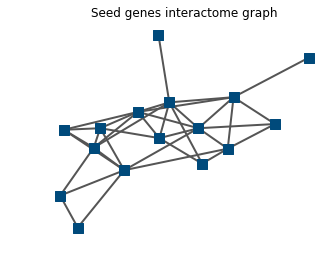

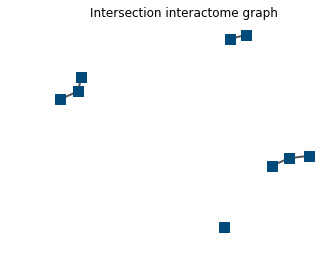

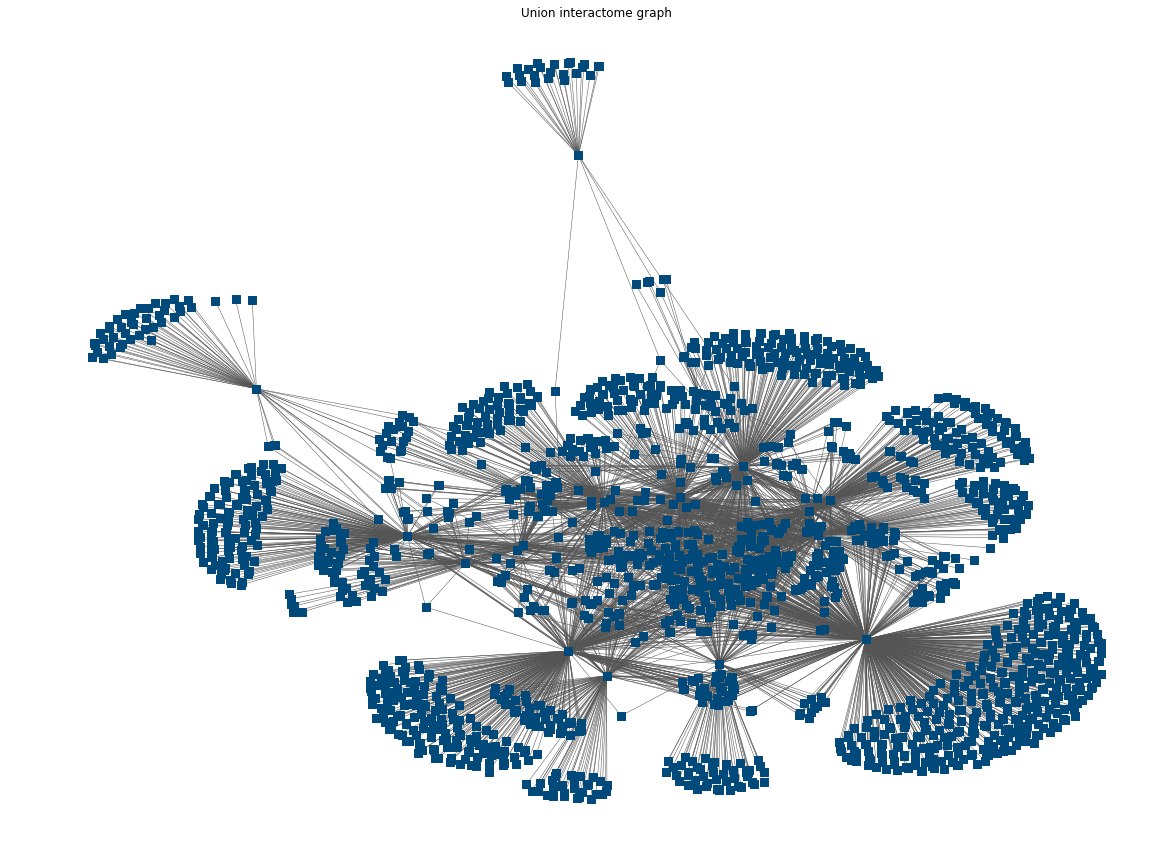

In [34]:
plt.figure(figsize=(5, 4))
plt.title('Seed genes interactome graph')
show_graph(SGI_Graph, node_size=100, edge_width = 2, save_as = '../../Images/SGI_Graph', save = True, label = False)
plt.show()

plt.figure(figsize=(5, 4))
plt.title('Intersection interactome graph')
show_graph(I_Graph, node_size=100, edge_width = 2, save_as = '../../Images/I_Graph', save = True, label = False)
plt.show()

plt.figure(figsize=(20, 15))
plt.title('Union interactome graph')
show_graph(U_Graph, node_size=50, edge_width = 0.5, save_as = '../../Images/U_Graph', save = True, label = False)
plt.show()

### 1.1 - Global measures calculation

In [35]:
def print_global_measures(G, interactome='', display=True):
    n_nodes = G.number_of_nodes()
    n_links = G.number_of_edges()
    n_conn_comp = nx.number_connected_components(G)
    n_iso_nodes = nx.number_of_isolates(G)   
    l = []
    for g in nx.connected_component_subgraphs(G): l.append(nx.average_shortest_path_length(g))
    avg_path_l = np.average(l)
    avg_degree = np.average(list(dict(G.degree()).values()))
    avg_cc = nx.average_clustering(G)
    l = []
    for g in nx.connected_component_subgraphs(G): l.append(nx.diameter(g))
    diameter = np.max(l)
    l = []
    for g in nx.connected_component_subgraphs(G): l.append(nx.radius(g))
    radius = np.max(l)
    degree_centralization=(n_nodes/(n_nodes-2))*((max(list(dict(G.degree()).values()))/(n_nodes-1)) - nx.density(G))
    if display:
        print(interactome+' Global measures: ')
        print('    Nunber of nodes: ', n_nodes)
        print('    Number of links: ', n_links)
        print('    Number of connected components: ', n_conn_comp)
        print('    Number of isolated nodes: ', n_iso_nodes)
        print('    Average path length: ', avg_path_l)
        print('    Average degree: ', avg_degree)
        print('    Average clustering coefficient: ', avg_cc)
        print('    Network diameter: ', diameter)
        print('    Network radius: ', radius)
        print('    Degree centralization: ', degree_centralization)
    return({
        'Nunber of nodes': n_nodes,
        'Number of links': n_links,
        'Number of connected components': n_conn_comp,
        'Number of isolated nodes': n_iso_nodes,
        'Average path length': avg_path_l,
        'Average degree': avg_degree,
        'Average clustering coefficient': avg_cc,
        'Network diameter':diameter,
        'Network radius': radius,
        'Degree centralization': degree_centralization
    })

#### a - Seed Genes Interactome case(SGI)

In [36]:
SGI_global_measures = print_global_measures(SGI_Graph, interactome='SGI', display=False)

#### b - Union Interactome case(U)

In [37]:
U_global_measures = print_global_measures(U_Graph, interactome='U', display=False)

#### c - Intersection Interactome case(I)

In [38]:
if (I_Graph.number_of_nodes() > 20):
    I_global_measures = print_global_measures(I_Graph, interactome='I', display=False)
else:
    print('Number of nodes lower than 20')

Number of nodes lower than 20


#### d - Saving results on matrix format

In [39]:
measures = list(SGI_global_measures.keys())
SGI_measures = list(SGI_global_measures.values())
U_measures = list(U_global_measures.values())
df_global_measures = pd.DataFrame({
    'SGI': SGI_measures,
    'U': U_measures,
}, index = measures)
writer = pd.ExcelWriter('../../Report/Results_Question1.xlsx')
df_global_measures.to_excel(writer,'Global_measures')
df_global_measures.head(10)

,SGI,U
Nunber of nodes,16.000000,1918.000000
Number of links,49.000000,3428.000000
Number of connected components,1.000000,1.000000
Number of isolated nodes,0.000000,0.000000
Average path length,1.975000,3.085069
Average degree,6.125000,3.574557
Average clustering coefficient,0.482738,0.242292
Network diameter,4.000000,6.000000
Network radius,2.000000,3.000000
Degree centralization,0.219048,0.373068


### 1.2 - Largest connected component: Intersection and Union interactomes

In [40]:
I_larg_comp = max(nx.connected_component_subgraphs(I_Graph), key=len)
U_larg_comp = max(nx.connected_component_subgraphs(U_Graph), key=len)

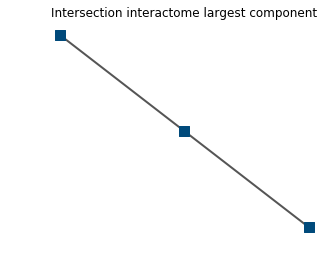

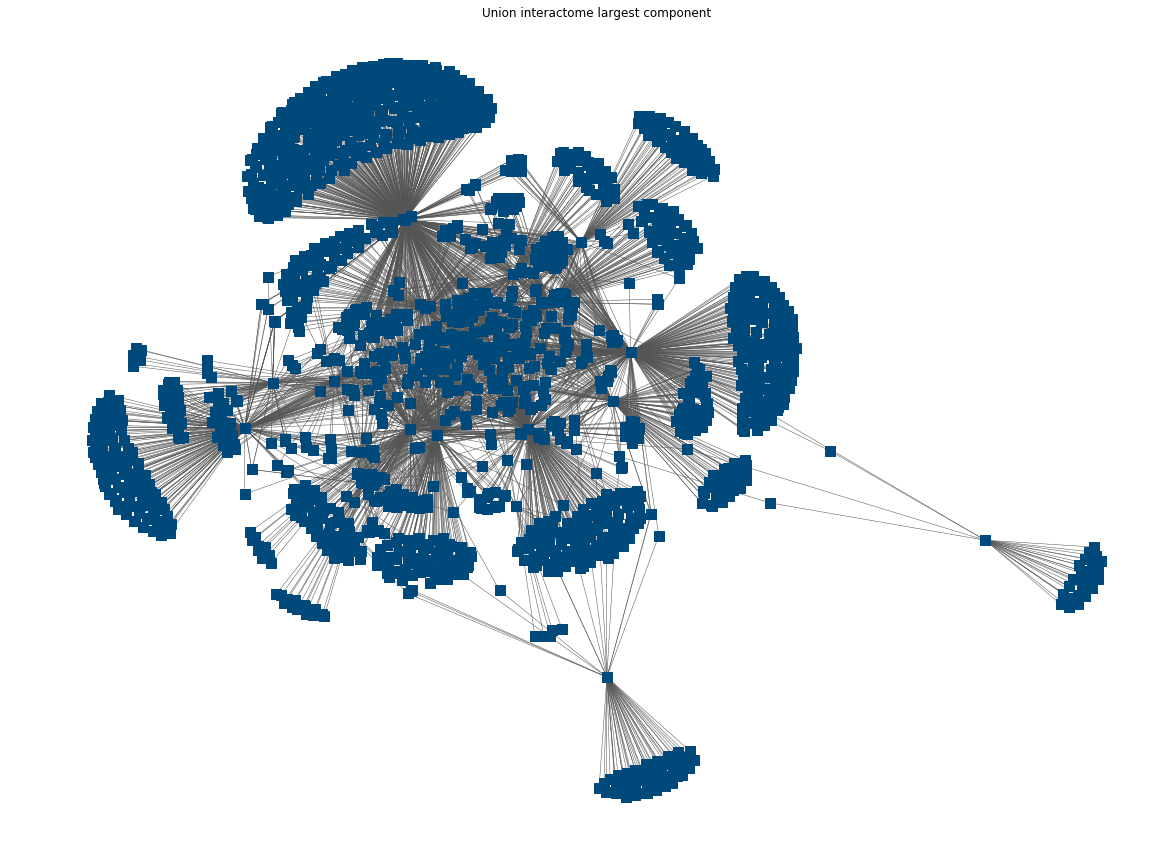

In [41]:
# take a look at the largest component graphs
plt.figure(figsize=(5, 4))
plt.title('Intersection interactome largest component')
show_graph(I_larg_comp, node_size=100, edge_width = 2, save_as = '../../Images/I_larg_comp_Graph', save = True, label = False)
plt.show()
plt.figure(figsize=(20, 15))
plt.title('Union interactome largest component')
show_graph(U_larg_comp, node_size=100, edge_width = 0.5, save_as = '../../Images/U_larg_comp_Graph', save = True, label = False)
plt.show()

#### a - Global measures

In [42]:
I_larg_global_measures = print_global_measures(I_larg_comp, interactome='I_Largest_component', display=False)
U_larg_global_measures = print_global_measures(U_larg_comp, interactome='U_Largest_component', display=False)

In [43]:
# Saving on the excel spreadsheet
measures = list(I_larg_global_measures.keys())
I_larg_measures = list(I_larg_global_measures.values())
U_larg_measures = list(U_larg_global_measures.values())
df_larg_comp_global_measures = pd.DataFrame({
    'I Largest component': I_larg_measures,
    'U Largest component': U_larg_measures,
}, index = measures)
df_larg_comp_global_measures.to_excel(writer,'Largest_comp_global_measures')
df_larg_comp_global_measures.head(10)

,I Largest component,U Largest component
Nunber of nodes,3.000000,1918.000000
Number of links,3.000000,3428.000000
Number of connected components,1.000000,1.000000
Number of isolated nodes,0.000000,0.000000
Average path length,1.333333,3.085069
Average degree,2.000000,3.574557
Average clustering coefficient,0.000000,0.242292
Network diameter,2.000000,6.000000
Network radius,1.000000,3.000000
Degree centralization,3.000000,0.373068


#### b - Local measures

In [44]:
I_larg_degree = dict(I_larg_comp.degree())
I_larg_between = dict(nx.betweenness_centrality(I_larg_comp))
I_larg_eigen = dict(nx.eigenvector_centrality(I_larg_comp))
I_larg_close = dict(nx.closeness_centrality(I_larg_comp))
I_between_over_degree = {k: I_larg_between[k]/I_larg_degree[k] for k in I_larg_between.keys()}

U_larg_degree = dict(U_larg_comp.degree())
U_larg_between = dict(nx.betweenness_centrality(U_larg_comp))
U_larg_eigen = dict(nx.eigenvector_centrality(U_larg_comp))
U_larg_close = dict(nx.closeness_centrality(U_larg_comp))
U_between_over_degree = {k: U_larg_between[k]/U_larg_degree[k] for k in U_larg_between.keys()}

In [45]:
#save on the excel spreadsheet: Intersection local measures for the largest components
nodes = list(I_larg_degree.keys())
I_degree = list(I_larg_degree.values())
I_between = list(I_larg_between.values())
I_eigen = list(I_larg_eigen.values())
I_close = list(I_larg_close.values())
I_btw_ovr_degree = list(I_between_over_degree.values())
df_I_local_measures = pd.DataFrame({
    'Node degree': I_degree,
    'Betweenness centrality': I_between,
    'Eigenvector centrality': I_eigen,
    'Closeness centrality': I_close,
    'Ratio Betweenness/Node degree': I_btw_ovr_degree
}, index = nodes)
df_I_local_measures.to_excel(writer,'I_largest_comp_local_measures')
df_I_local_measures.head(10)

,Node degree,Betweenness centrality,Eigenvector centrality,Closeness centrality,Ratio Betweenness/Node degree
P01579,4,1.0,0.816497,1.000000,0.25
Q9HD26,1,0.0,0.408248,0.666667,0.00
P38484,1,0.0,0.408248,0.666667,0.00


In [46]:
#save on the excel spreadsheet: Union local measures for the largest components
nodes = list(U_larg_degree.keys())
U_degree = list(U_larg_degree.values())
U_between = list(U_larg_between.values())
U_eigen = list(U_larg_eigen.values())
U_close = list(U_larg_close.values())
U_btw_ovr_degree = list(U_between_over_degree.values())
df_U_local_measures = pd.DataFrame({
    'Node degree': U_degree,
    'Betweenness centrality': U_between,
    'Eigenvector centrality': U_eigen,
    'Closeness centrality': U_close,
    'Ratio Betweenness/Node degree': U_btw_ovr_degree 
}, index = nodes)
df_U_local_measures.to_excel(writer,'U_largest_comp_local_measures')
writer.save()
df_U_local_measures.head(10)

,Node degree,Betweenness centrality,Eigenvector centrality,Closeness centrality,Ratio Betweenness/Node degree
P01579,125,0.054432,0.074814,0.372378,0.000435
A8K4S9,1,0.000000,0.002235,0.271376,0.000000
P38484,2,0.000268,0.016740,0.351228,0.000134
E1P587,1,0.000000,0.002235,0.271376,0.000000
Q9HD26,1,0.000000,0.002235,0.271376,0.000000
P29460,199,0.073900,0.126892,0.385482,0.000371
Q6UW14,1,0.000000,0.003790,0.278270,0.000000
Q9NPF7,3,0.000000,0.012704,0.337203,0.000000
P01374,144,0.052433,0.089591,0.423459,0.000364
O43889,1,0.000000,0.002676,0.297532,0.000000



### 2 - Apply clustering methods for disease modules discovery

#### a- Markov clustering algorithm (MCL)

In [47]:
# returns the MCL clusters
def markov_clustering_(net, inflation=1.4, display = False):
    result = mc.run_mcl(nx.to_scipy_sparse_matrix(net), inflation=inflation)
    clusters = mc.get_clusters(result)
    if display: 
        mc.draw_graph(nx.to_scipy_sparse_matrix(net), 
                      clusters, 
                      node_size=50, with_labels=False, 
                      edge_color="silver")
    labels = dict(zip(range(len(net)), net.nodes()))
    d={}
    for c in range(len(clusters)):
        d[c]=[labels.get(item) for item in clusters[c]]
    return d

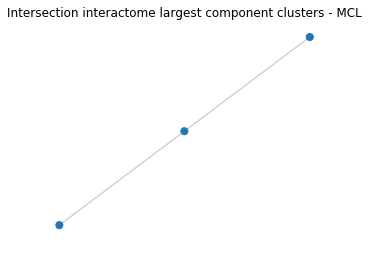

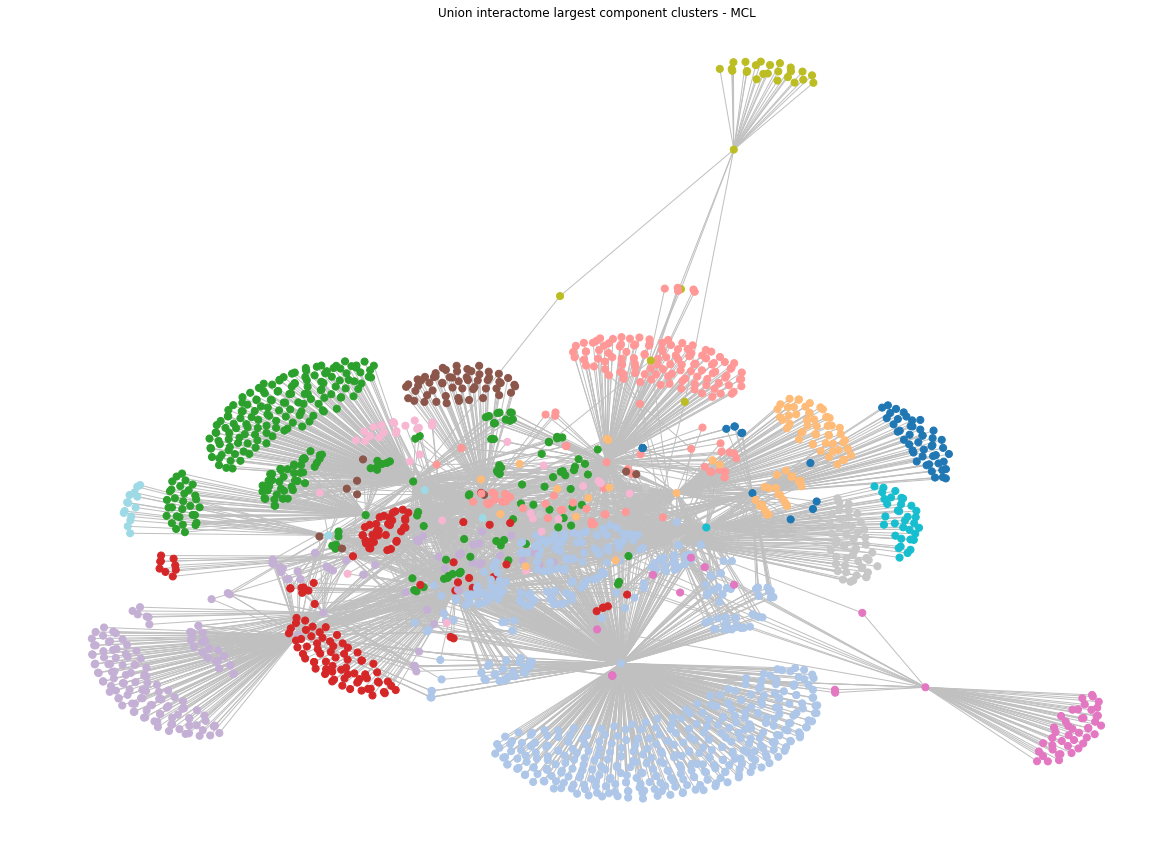

In [48]:
# create the various clusters using MCL
plt.figure(figsize=(5, 4))
plt.title('Intersection interactome largest component clusters - MCL')
I_LCC_MCL_clusters = markov_clustering_(I_larg_comp, inflation=2, display=True)
plt.show()

plt.figure(figsize=(20, 15))
plt.title('Union interactome largest component clusters - MCL')
U_LCC_MCL_clusters = markov_clustering_(U_larg_comp, inflation=2, display=True)
plt.show()

#### b - Louvain algorithm

In [49]:
# returns the Louvain clusters
def louvain_clustering(net, display = False):
    clusters = community.best_partition(net)
    
    # create the output dictionary with cluster ID as keys and list of nodes in the cluster as values
    res={}
    for partition in set(clusters.values()):
        res[partition] = [e for e in clusters.keys() if clusters[e] == partition]
    
    # tranform the clusters into the MCL format to plot them using mc.draw_graph
    labels = dict(zip(net.nodes(), range(len(net))))
    clusters_markov_format = []
    for cluster in list(res.values()):
        clusters_markov_format.append(tuple([labels[e] for e in cluster]))
    
    # plot the clusters 
    if display: 
        mc.draw_graph(nx.to_scipy_sparse_matrix(net), 
                      clusters_markov_format, 
                      node_size=50, with_labels=False, 
                      edge_color="silver")
        
    return res

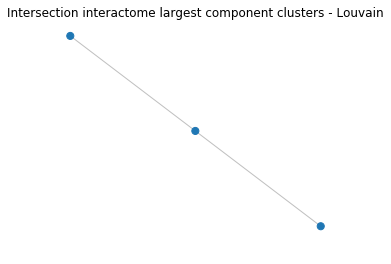

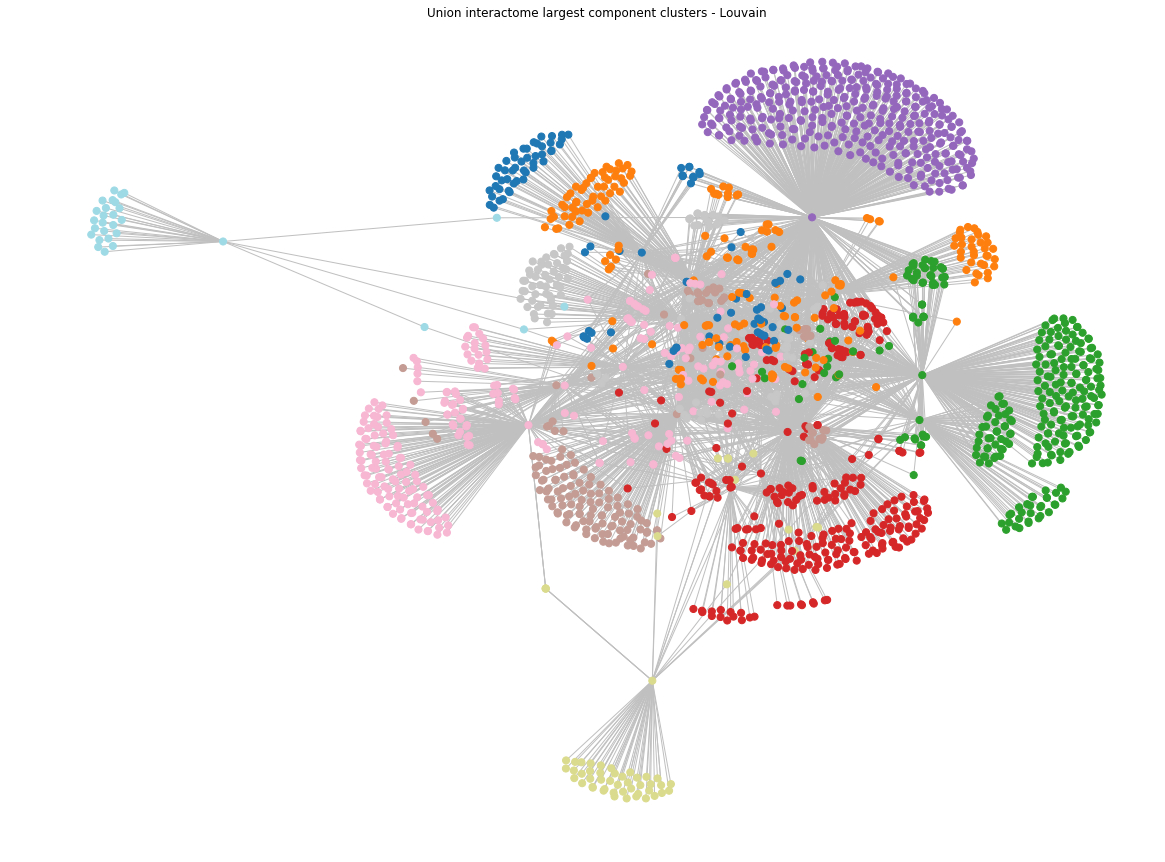

In [50]:
# create the various clusters using Louvain algorithm
plt.figure(figsize=(5, 4))
plt.title('Intersection interactome largest component clusters - Louvain')
I_LCC_LV_clusters = louvain_clustering(I_larg_comp, display=True)
plt.show()

plt.figure(figsize=(20, 15))
plt.title('Union interactome largest component clusters - Louvain')
U_LCC_LV_clusters = louvain_clustering(U_larg_comp, display=True)
plt.show()

#### c - Hypergeometric test: finding modules with statistically overrepresented (p<0.05) seed genes

In [59]:
# Reading the seed genes official symbols from the file system
seed_genes = list(pd.read_csv('../../Data/Manually_integrated_basic_info.csv')['Uniprot AC'])

In [60]:
def hypergeometric_test(net, modules, seed_genes):
    d = {}
    # number of nodes in the network
    M = len(net.nodes())
    # number of seed genes in the network
    n = len(set(seed_genes).intersection(set(net.nodes())))
    for moduleID in list(modules.keys()):
        if (len(modules[moduleID])>=10):
            # number of nodes in the module
            N = len(modules[moduleID])
            # number of seed genes in the module
            x = len(set(seed_genes).intersection(set(modules[moduleID])))
            pval = hypergeom.sf(x, M, n, N)
            d[moduleID] = [moduleID, x, N, set(seed_genes).intersection(set(modules[moduleID])), 
                           set(modules[moduleID]), 1-pval]
    return d

In [61]:
I_LCC_MCL_HT = hypergeometric_test(I_larg_comp, I_LCC_MCL_clusters, seed_genes)
U_LCC_MCL_HT = hypergeometric_test(U_larg_comp, U_LCC_MCL_clusters, seed_genes)
I_LCC_LV_HT = hypergeometric_test(I_larg_comp, I_LCC_LV_clusters, seed_genes)
U_LCC_LV_HT = hypergeometric_test(U_larg_comp, U_LCC_LV_clusters, seed_genes)

In [62]:
# Function to store the store the results of the hypergeometric test
def generate_putative_table(louvain, markov):
    
    l = [["Louvain"]+v for k,v in louvain.items()]
    m = [["MCL"]+v for k,v in markov.items()]

    rows = l + m

    cols = ["Clustering Algorithm","Module ID" ,"Number of Seed Genes", "Number of Genes", "List of Seed Genes", 
            "List of All Genes", "P-Value"]

    put_table = pd.DataFrame(data = rows, columns = cols)
    put_table["Id"] = np.arange(1, put_table.shape[0]+1)

    put_mod = put_table[put_table["P-Value"] > 0.95]
    return put_mod

In [63]:
# Store the result of the hypergeometric test in tables for both U-LCC and I-LCC
putative_disease_modules_I = generate_putative_table(I_LCC_MCL_HT, I_LCC_LV_HT)
# Save the table on an excel file
writer = pd.ExcelWriter('../../Report/Results_Question2.xlsx')
putative_disease_modules_I.to_excel(writer,'putative_disease_modules_I', index=False)
putative_disease_modules_I.head(10)

,Clustering Algorithm,Module ID,Number of Seed Genes,Number of Genes,List of Seed Genes,List of All Genes,P-Value,Id


In [64]:
putative_disease_modules_U = generate_putative_table(U_LCC_MCL_HT, U_LCC_LV_HT)
# Save the table on an excel file
putative_disease_modules_U.to_excel(writer,'putative_disease_modules_U', index=False)
writer.save()
putative_disease_modules_U

,Clustering Algorithm,Module ID,Number of Seed Genes,Number of Genes,List of Seed Genes,List of All Genes,P-Value,Id
9,Louvain,9,1,36,{Q13651},"{Q9Y5Q3, Q9Y3Z3, Q71UZ1, Q9UBW5, Q9UHF4, Q6UXL...",0.956589,10
11,Louvain,11,1,29,{P82251},"{Q16288, Q9UHI5, Q01959, Q15303, Q6IB77, Q9H3N...",0.970920,12
12,Louvain,12,1,35,{P24394},"{P43629, Q05513, Q6UVM3, Q8WUT4, Q7Z628, Q96KC...",0.958773,13
13,Louvain,13,1,17,{P51681},"{P51681, P63096, Q08708, P55160, Q99500, Q0835...",0.989589,14
23,MCL,9,1,29,{P82251},"{Q16288, Q9UHI5, Q01959, Q15303, Q6IB77, Q9H3N...",0.970920,24
